## Import Packages
import common packages

In [1]:
import os
import time
import datetime
import numpy as np
import sunpy.map
import matplotlib.pyplot as plt

Tell python where your local copy of *chmap* is located

In [2]:
import sys
sys.path.append("/Users/turtle/GitReps/CHD")

import *chmap* functions

In [3]:
import chmap.database.db_classes as db_class
import chmap.database.db_funs as db_funcs
import chmap.utilities.datatypes.datatypes as psi_dtypes
from chmap.database.db_funs import init_db_conn
import chmap.data.corrections.lbcc.LBCC_theoretic_funcs as lbcc_funcs
import chmap.utilities.plotting.psi_plotting as psi_plots

## Set parameters

In [13]:
###### ------ PARAMETERS TO UPDATE -------- ########

# TIME RANGE FOR HISTOGRAM CALCULATION
hist_query_time_min = datetime.datetime(2011, 2, 1, 0, 0, 0)
hist_query_time_max = datetime.datetime(2011, 2, 2, 0, 0, 0)

# TIME RANGE FOR FIT PARAMETER CALCULATION
calc_query_time_min = datetime.datetime(2010, 11, 1, 0, 0, 0)
calc_query_time_max = datetime.datetime(2011, 5, 1, 0, 0, 0)
weekday_calc = 0  # start at 0 for Monday
days = 180  # days for moving average
# TIME WINDOWS FOR IMAGE INCLUSION
image_freq = 2      # number of hours between window centers
image_del = np.timedelta64(30, 'm') # one-half window width

# TIME RANGE FOR LBC CORRECTION AND IMAGE PLOTTING
lbc_query_time_min = datetime.datetime(2010, 4, 1, 0, 0, 0)
lbc_query_time_max = datetime.datetime(2011, 4, 1, 6, 0, 0)
n_images_plot = 1
plot = True  # true if you want images plotted

# TIME RANGE FOR BETA AND Y PLOT GENERATION
plot_query_time_min = datetime.datetime(2010, 8, 1, 0, 0, 0)
plot_query_time_max = datetime.datetime(2014, 6, 1, 0, 0, 0)
weekday_plot = 0  # start at 0 for Monday

# TIME RANGE FOR HISTOGRAM PLOTTING
hist_plot_query_time_min = datetime.datetime(2011, 4, 1, 0, 0, 0)
hist_plot_query_time_max = datetime.datetime(2011, 4, 1, 3, 0, 0)
n_hist_plots = 1  # number of histograms to plot

# INSTRUMENTS
inst_list = ["AIA", "EUVI-A", "EUVI-B"]
wavelengths = [193, 195]

# MAP AND BINNING PARAMETERS
n_mu_bins = 18
mu_bin_edges = np.linspace(0.1, 1.0, n_mu_bins + 1, dtype='float')
n_intensity_bins = 200
image_intensity_bin_edges = np.linspace(0, 5, num=n_intensity_bins + 1, dtype='float')
R0 = 1.01
log10 = True
lat_band = [- np.pi / 64., np.pi / 64.]

# DATABASE FILE-SYSTEM PATHS
raw_data_dir = "/Volumes/extdata2/CHD_DB_example/raw_images"
hdf_data_dir = "/Volumes/extdata2/CHD_DB_example/processed_images"

# DATABASE CONNECTION
create = True  # set to False to disallow writes to the database
db_type = "sqlite"
sqlite_path = "/Volumes/extdata2/CHD_DB_example/chd_example.db"

# STORAGE PATHS AND TITLES FOR BETA/Y PLOTS
year = "2011"  # used for naming plot file
time_period = "6 Month"  # used for plot file and title
plot_week = 5  # index of week you want to plot
image_out_path = None  # path to save plots to

In [7]:
# connect to database
db_session = init_db_conn(db_type, db_class.Base, db_loc=sqlite_path)

Attempting to connect to SQLite DB server /Volumes/extdata2/CHD_DB_example/chd_example.db
Connection successful



## Choose an image for demonstration

In [8]:
query_instrument = ["EUVI-A", ]
query_pd_all = db_funcs.query_euv_images(db_session=db_session, time_min=hist_query_time_min,
                                         time_max=hist_query_time_max, instrument=query_instrument,
                                         wavelength=wavelengths)

In [9]:
use_image = query_pd_all.loc[4]
print(use_image)

data_id                                                    30763
date_obs                                     2011-02-01 10:00:30
instrument                                                EUVI-A
wavelength                                                   195
distance                                             143867000.0
cr_lon                                                    288.31
cr_lat                                                  -4.39192
cr_rot                                                    2106.2
flag                                                           0
time_of_download                             2020-09-30 18:54:44
fname_raw           2011/02/01/sta_euvi_20110201T100030_195.fits
fname_hdf           2011/02/01/euvia_lvl2_20110201T100030_195.h5
Name: 4, dtype: object


In [28]:
# plot the raw fits file using sunpy
# fits_infile = os.path.join(raw_data_dir, use_image.fname_raw)
# map_sta = sunpy.map.Map(fits_infile)  

# map_sta.plot()
# plt.colorbar()
# plt.show()

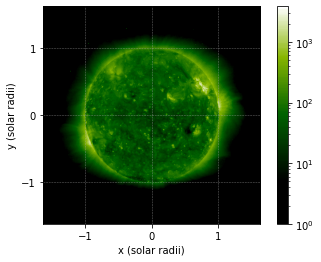

In [10]:
# plot deconvolved image
image_path = os.path.join(hdf_data_dir, use_image.fname_hdf)
deconv_image = psi_dtypes.read_los_image(image_path)

psi_plots.PlotImage(deconv_image)
plt.colorbar()
plt.show()

## Generate equtorial histogram

In [11]:
# add coordinates to los object
deconv_image.get_coordinates(R0=R0)
# perform 2D histogram on mu and image intensity
temp_hist = deconv_image.mu_hist(image_intensity_bin_edges, mu_bin_edges, lat_band=lat_band, log10=log10)
# query LBCC method
meth_name = 'LBCC'
method_id = db_funcs.get_method_id(db_session, meth_name)
# create histogram object
hist_lbcc = psi_dtypes.create_lbcc_hist(image_path, use_image.data_id, method_id[1], mu_bin_edges,
                                         image_intensity_bin_edges, lat_band, temp_hist)


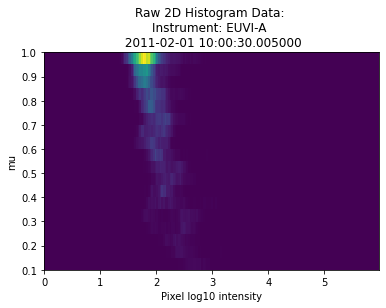

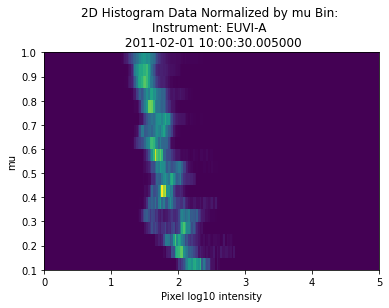

In [12]:
plot_hist = hist_lbcc.hist
figure = "LBCC Histogram Plot: "
# plot histogram
psi_plots.Plot_LBCC_Hists(plot_hist, hist_lbcc.date_obs, hist_lbcc.instrument, image_intensity_bin_edges, 
                          mu_bin_edges, figure, 0)

In [ ]:
# add this histogram and meta data to database
# db_funcs.add_hist(db_session, hist_lbcc)

## Calculate correction coefficient
The coefficients are already in the example database, so we show only commented code here:

In [39]:
# Calculate weekly LBCCs over the specified time range
# lbcc_funcs.calc_theoretic_fit(db_session, inst_list, calc_query_time_min,
#                               calc_query_time_max, weekday=weekday_calc, image_freq=image_freq,
#                               image_del=image_del, number_of_days=days, n_mu_bins=n_mu_bins,
#                               n_intensity_bins=n_intensity_bins, lat_band=lat_band, create=create,
#                               wavelengths=wavelengths)

### Plot LBCCs v time

Generating plots for AIA.
Generating plots for EUVI-A.
Generating plots for EUVI-B.
Theoretical plots of beta and y over time hvae been generated and saved.
Total elapsed time for plot creation: 162.126 seconds.


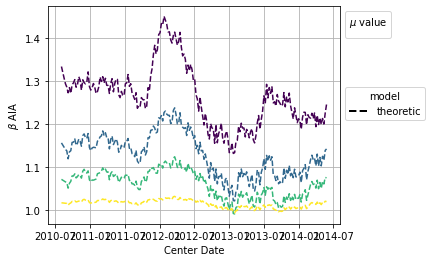

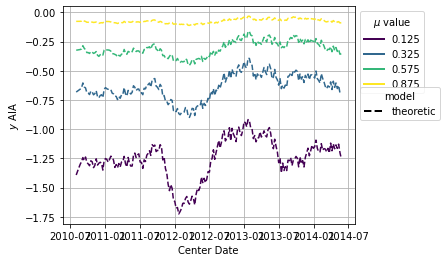

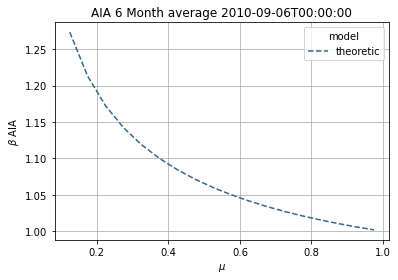

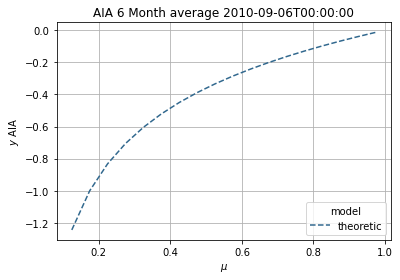

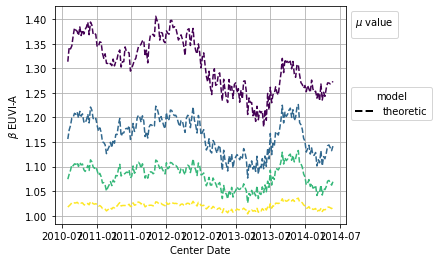

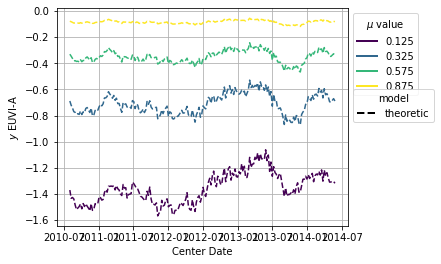

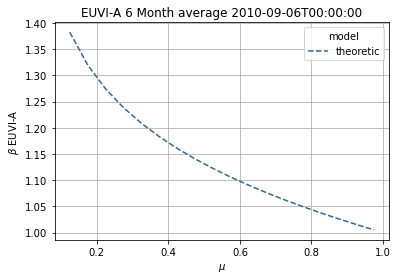

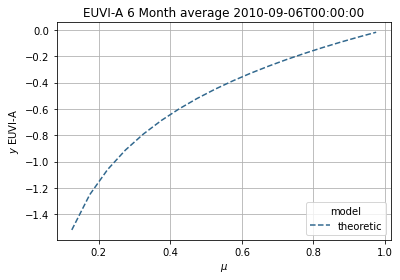

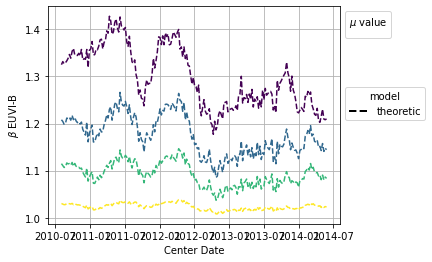

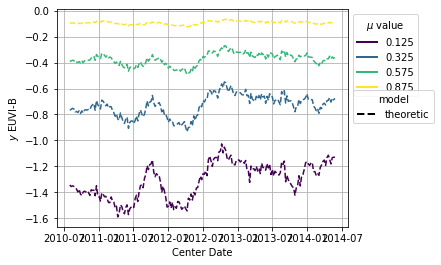

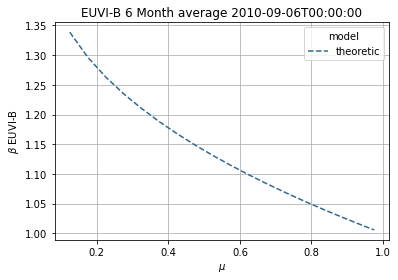

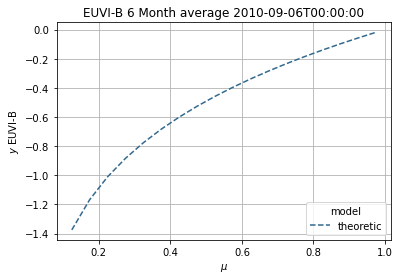

In [14]:
lbcc_funcs.generate_theoretic_plots(db_session, inst_list, plot_query_time_min, plot_query_time_max,
                                    weekday=weekday_plot, image_out_path=image_out_path,
                                    year=year, time_period=time_period, plot_week=plot_week, n_mu_bins=n_mu_bins)
# Note: 'image_out_path' must be set to None for images to render in notebook

## Apply correction to deconvolved image

plot before and after?